In [1]:
# basic
import numpy as np
import pandas as pd
import pprint

# plot
#import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
import lightgbm as lgb

# optimization
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime
#import sys
#import gc

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [3]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [4]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [5]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [6]:
# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# Encoding

In [7]:
cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

del cat_cols

# Create Model

In [8]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_X = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

#del train_test

In [9]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    args['max_depth'] = int(args['max_depth'])
    args['num_leaves'] = int(args['num_leaves'])
    args['min_data_in_leaf'] = int(args['min_data_in_leaf'])
    
    model = lgb.LGBMRegressor(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    scores = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    
    #history.append((model, scores))
    
    return {
        'loss':scores['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [10]:
# 変数候補すべてを最適化
param_space = {
    'alpha' : hp.loguniform(
        label='alpha', low=np.log(1e-8), high=np.log(1.0)
    ),
    'bagging_fraction': hp.quniform(
        label='bagging_fraction', low=0.6, high=0.95, q=0.05
    ),
    'feature_fraction': hp.quniform(
        label='feature_fraction', low=0.6, high=0.95, q=0.05
    ),
    'gamma': hp.quniform(
        label='gamma', low=0.1, high=0.4, q=0.1
    ),
    'lambda' : hp.loguniform(
        label='lambda', low=np.log(1e-6), high=np.log(10.0)
    ),
    'max_depth': hp.quniform(
        label='max_depth', low=3, high=9, q=1
    ),
    'min_child_weight': hp.quniform(
        label='min_child_weight', low=1, high=5, q=1
    ),
    'min_data_in_leaf': hp.quniform(
        label='min_data_in_leaf', low=5, high=20, q=2
    ),
    'num_leaves': hp.quniform(
        label='num_leaves', low=20, high=100, q=10
    )
}

#history = []

f = partial(objective, train_X, train_y)
trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest, 
    trials=trials,
    max_evals=1000
)

100%|████████████████████████████████████████████| 1000/1000 [03:49<00:00,  4.36trial/s, best loss: 2.8618792384229885]


In [11]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df)

,loss,alpha,bagging_fraction,feature_fraction,gamma,lambda,max_depth,min_child_weight,min_data_in_leaf,num_leaves
0,2.861879,8.723252e-02,0.60,0.60,0.2,1.348234,6,4.0,6,70
1,2.876474,9.247029e-02,0.60,0.60,0.2,1.605680,6,4.0,6,70
2,2.884044,8.207400e-02,0.65,0.60,0.2,1.487244,7,1.0,6,90
3,2.891272,1.580667e-03,0.95,0.60,0.2,0.002853,6,5.0,6,30
4,2.893477,3.009222e-02,0.70,0.60,0.2,1.813644,6,4.0,6,70
...,...,...,...,...,...,...,...,...,...,...
995,3.204224,2.462851e-02,0.70,0.85,0.1,0.000010,4,4.0,16,60
996,3.263165,3.226475e-08,0.80,0.60,0.1,0.000010,3,3.0,14,70
997,3.276374,2.704017e-03,0.65,0.70,0.2,4.384126,3,2.0,12,30
998,3.286628,1.852440e-02,0.80,0.85,0.2,0.000006,3,4.0,18,90


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


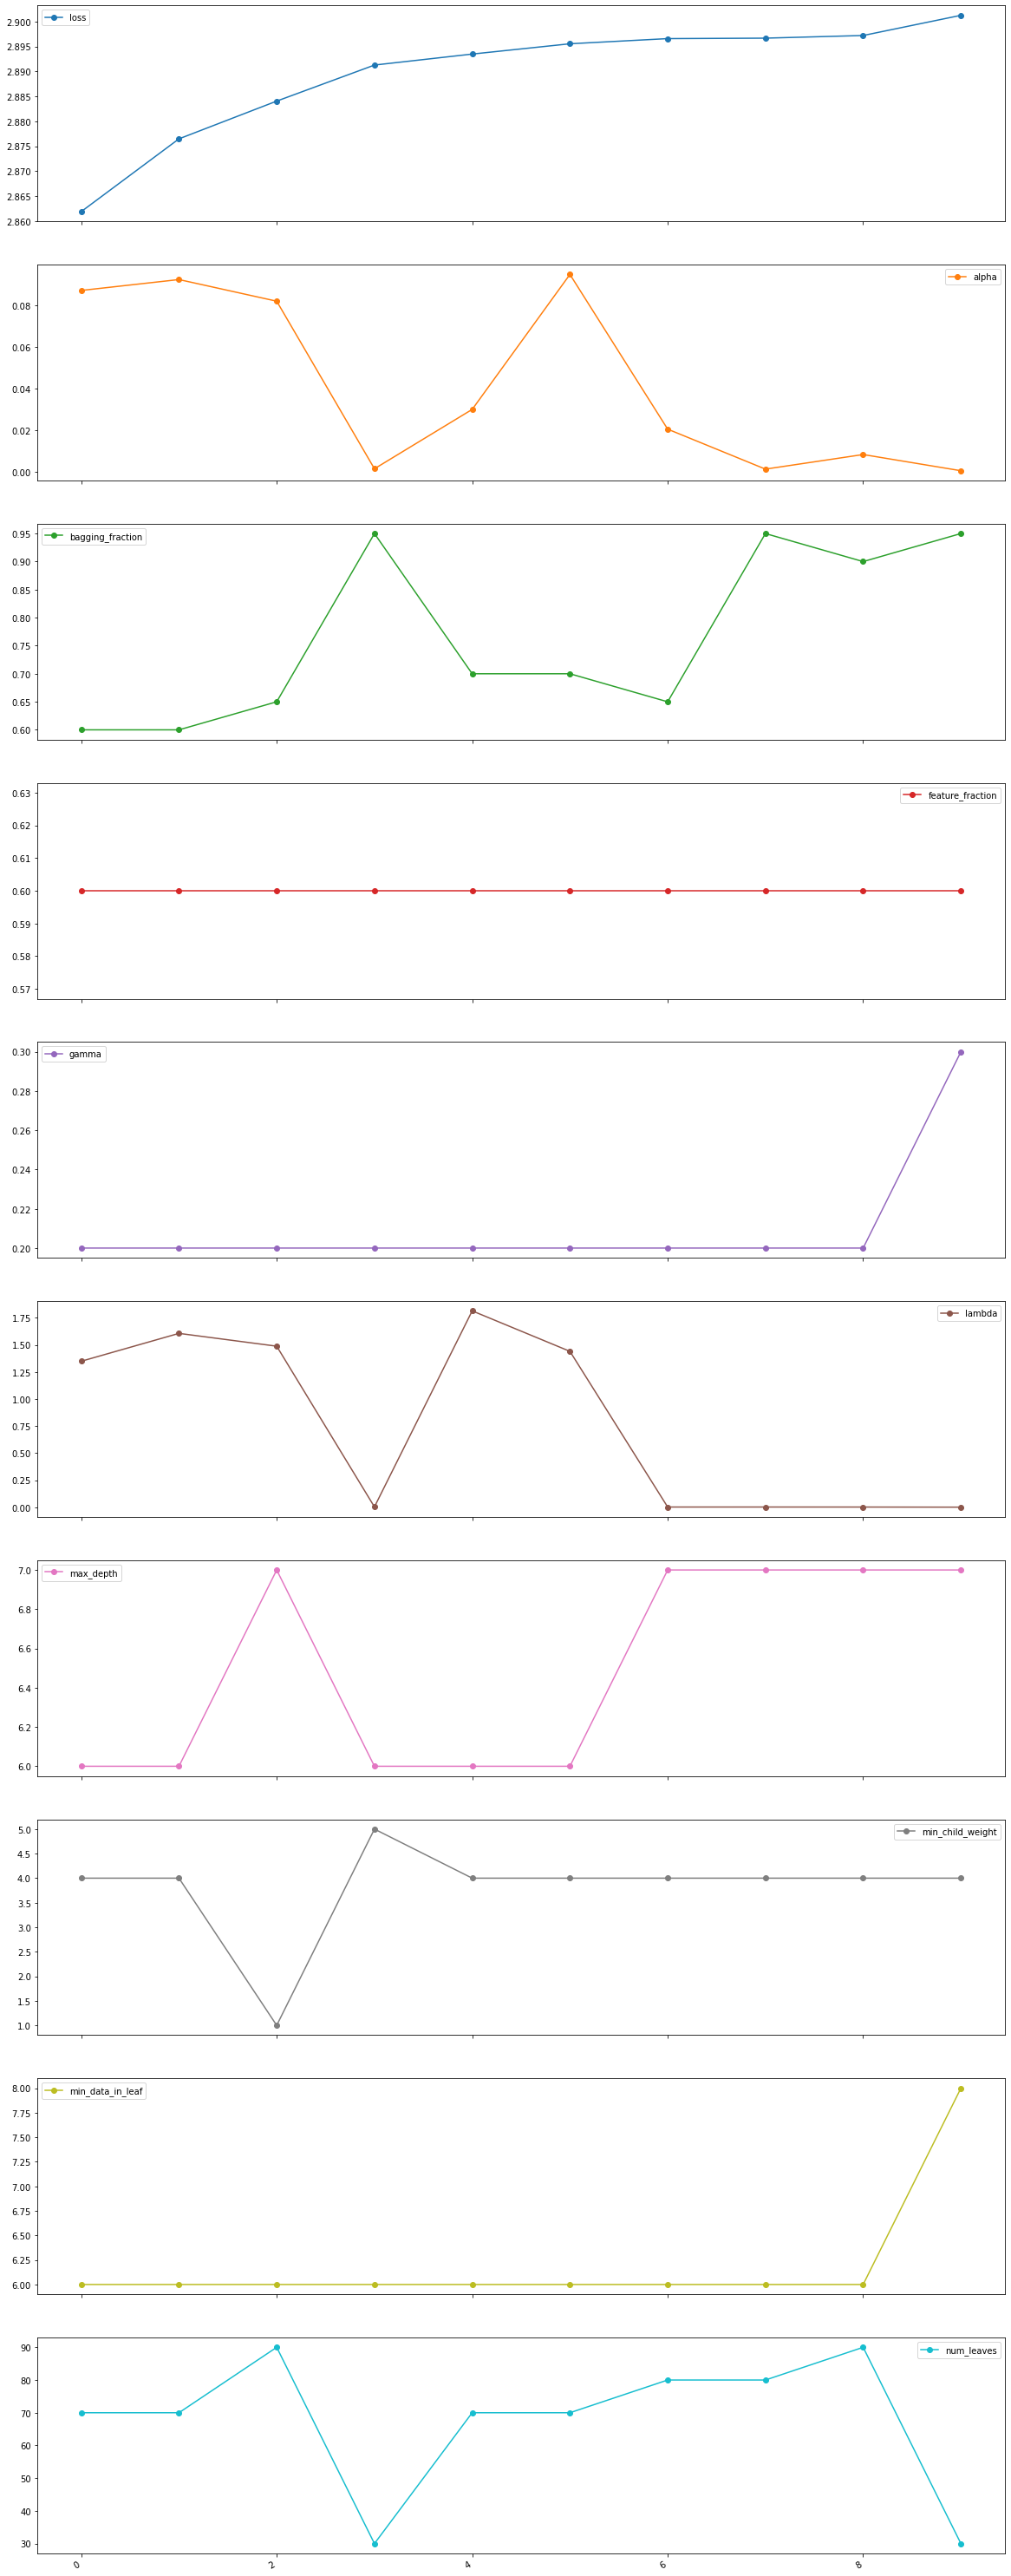

In [12]:
opt_params_df.iloc[:10, :].plot.line(figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True)
plt.show()

In [13]:
# ベストスコアとそのときのパラメータを記録
best_loss = losses[0]
best_params = opt_params[0]

In [14]:
print("best_loss: ")
pprint.pprint(best_loss)
print("\nbest_params: ")
pprint.pprint(best_params)

best_loss: 
2.8618792384229885

best_params: 
{'alpha': 0.08723252133566156,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.6000000000000001,
 'gamma': 0.2,
 'lambda': 1.3482338260993783,
 'max_depth': 6,
 'min_child_weight': 4.0,
 'min_data_in_leaf': 6,
 'num_leaves': 70}


# Create Submission

In [15]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})
importance_list = []

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(train_X, train_y)
submission = pd.concat(
    [submission, pd.Series(best_model.predict(test_treated.drop(['id', 'mpg'], axis=1)), name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,35.791936
1,2,27.076850
2,5,27.154303
3,6,32.778416
4,8,24.295268
...,...,...
495,992,27.747788
496,993,31.945265
497,996,17.877529
498,998,27.016333


### Save files

In [270]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_treated.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_treated.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_lightgbm.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_lightgbm.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '.pickle', 'wb'))
# best train score
pickle.dump(best_loss, open('../logs/logs_test_score' + dt + '.pickle', 'wb'))

# Check Importance

## lgb importance method

In [271]:
importance_df = pd.DataFrame(
    best_model.feature_importances_.tolist(), 
    index=train_X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
display(importance_df)

,importance
acceleration,449
weight,333
horsepower,289
car name,276
displacement,261
model year,246
car_brand,132
origin,77
cylinders,61


## eli5 permutation importance

In [16]:
perm_df = eli5.explain_weights_df(best_model)
perm_df.set_index('feature')

,weight
feature,
cylinders,0.361121
displacement,0.186787
acceleration,0.094191
model_year,0.090300
origin,0.082709
horsepower,0.065008
weight,0.061662
car_name,0.035324
car_brand,0.022898


# Feature Importance

In [17]:
from collections import defaultdict
from sklearn.model_selection import KFold

In [18]:
def permuted(df):
    for col in df.columns:
        permuted_df = df.copy()
        permuted_df[col] = np.random.permutation(permuted_df[col])
        yield col, permuted_df

In [38]:
def pimp(clf, x, y, kf=None, eval_func=RMSE):
    base_scores=[]
    perm_scores = defaultdict(list)
    
    if kf is None:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for tr_idx, va_idx in kf.split(x, y):
        tr_x, tr_y = x.iloc[tr_idx], y.iloc[tr_idx]
        va_x, va_y = x.iloc[va_idx], y.iloc[va_idx]
        
        clf.fit(tr_x, tr_y)
        
        y_pred_base = clf.predict(va_x)
        base_score = eval_func(va_y, y_pred_base)
        base_scores.append(base_score)
        
        perm_va_x_gen = permuted(va_x)
        for col, perm_va_x in perm_va_x_gen:
            y_pred_perm = clf.predict(perm_va_x)
            perm_score = eval_func(va_y, y_pred_perm)
            perm_scores[col].append(perm_score)
            
    np_base_score = np.array(base_score)
    dict_perm_score = {name:np.array(scores) for name, scores in perm_scores.items()}
    return np_base_score, dict_perm_score

In [39]:
def score_diff_stat(base, perm):
    mean_base_score = base.mean()
    for col, scores in perm.items():
        score_diff = scores - mean_base_score
        yield col, score_diff.mean(), score_diff.std()
# score_diff.std()が0になってしまう？

In [40]:
# Permutation Importanceを計算
base_score, perm_scores = pimp(best_model, train_X, train_y)
pprint.pprint(perm_scores)

{'acceleration': array([3.94725794, 3.00859318, 3.53283279, 3.78250761, 3.72227408]),
 'car name': array([3.03537774, 2.49359268, 2.91933249, 2.92626425, 4.0997362 ]),
 'car_brand': array([3.01366022, 2.31276315, 2.90054426, 2.74423397, 3.77091811]),
 'cylinders': array([4.82997889, 4.62796879, 4.58195783, 4.15110905, 5.21722604]),
 'displacement': array([3.45326907, 3.04280918, 3.54541661, 3.35306875, 4.00168635]),
 'horsepower': array([3.37091944, 2.52615328, 3.07576639, 3.03010081, 3.57130669]),
 'model year': array([3.64618404, 2.94979162, 3.27605466, 3.33478166, 4.48775403]),
 'origin': array([3.77340535, 3.12590717, 3.64889496, 2.88160617, 4.24778118]),
 'weight': array([3.23203511, 2.89357228, 3.24989395, 3.1692465 , 4.05277017])}


In [49]:
# カラム名、base scoreとの差、95%信頼区間を取り出す
diff_stat = list(score_diff_stat(base_score, perm_scores))
sorted_diff_stat = sorted(diff_stat, key=lambda x:x[1])
cols = [name for name, _, _ in sorted_diff_stat]
diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stat]
diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stat]

In [50]:
sorted_diff_stat

[('car_brand', -0.6257256608533839, 0.4751427328169712),
 ('car name', -0.4792889309455447, 0.5355503973742483),
 ('horsepower', -0.4593002821703019, 0.3547387929405821),
 ('weight', -0.25464600296229517, 0.3883737328016599),
 ('displacement', -0.0948996105939421, 0.31125393754843655),
 ('origin', -0.038630636590580726, 0.48417874152173385),
 ('model year', -0.03523640447503453, 0.5233802619462418),
 ('acceleration', 0.02454351576456588, 0.3234541621450852),
 ('cylinders', 1.1074985167279068, 0.34731457043294894)]

In [52]:
base_score

array(3.5741496)

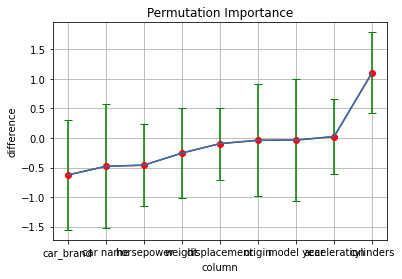

In [51]:
# グラフにプロットする
plt.plot(cols, diff_means, marker='o', color='r')
plt.errorbar(cols, diff_means, yerr=diff_stds_95, ecolor='g', capsize=4)

plt.title('Permutation Importance')
plt.grid()
plt.xlabel('column')
plt.ylabel('difference')
plt.show()